In [2]:
import numpy as np
import scipy
import time
import math
from scipy.stats import norm

import mystic
from mystic.solvers import DifferentialEvolutionSolver, diffev2
from mystic.strategy import Best1Bin
from mystic.monitors import Monitor,VerboseMonitor

from copy import deepcopy

from tomography import *

from NestedForLoop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch
from efficiencies import finding_file, get_channels_eff, set_raw_counts
from optimization import Optimizer, function_fidelity, FidelityResults
from constants import *

from densitymatrix import DensityMatrix

from pathlib import Path
import fnmatch

In [3]:
######################################################################################################
#----- COUNTING THE FILES AND SAVING THEM IN AN ARRAY TO MAKES THE REST OF THE ANALYSIS EASIER -------
######################################################################################################

n_files=0
working_dir=r"C:\Users\Simon\Documents\Travail\ChannelCertification\Stability\StabilityWeekEnd21052022"
os.chdir(working_dir)

filenames = [i for i in glob.glob("StateTomography*")]

index_to_file = {}

for index, filename in enumerate(filenames):
    index_to_file[n_files] = f"{filename}"
    n_files+=1

In [4]:
os.chdir(working_dir)
qubit_number=2

state = []
xp_counts_corrected_with_eff=[]

#####################################################################
#---------------------- STATE TOMOGRAPHY ----------------------------
#####################################################################

for index in range(len(index_to_file)):
    os.chdir(f"{working_dir}\\{index_to_file[index]}\\StateTomo")
    datafiles=[i for i in glob.glob("*")]
                
    ### Calculating the efficiencies of each detector
    efficiencies=get_channels_eff(datafiles, os.getcwd())

    ### Opening the data files and writing the data in counts_aux array
    counts_aux=set_raw_counts(datafiles, qubit_number, os.getcwd())
    xp_counts=np.array(np.transpose(counts_aux))

    statetomo=LRETomography(int(qubit_number), xp_counts)
    statetomo.run(correct_eff=efficiencies, print_nc=False)
    xp_counts_corrected_with_eff.append(statetomo.xp_counts)
    
    state.append(DensityMatrix(statetomo.quantum_state.get_density_matrix()))
    print('\n Fast maximum likelihood estimation: \n', state[-1], '\n')



 Fast maximum likelihood estimation: 
 array([[6.92942771e-03+9.97112687e-20j, 1.45574903e-02-4.28411760e-03j,
        9.98833585e-03-1.77033717e-03j, 4.66693786e-05+2.01104992e-04j],
       [1.45574903e-02+4.28411760e-03j, 4.81348605e-01+7.28672354e-18j,
        4.92165383e-01-3.47200923e-04j, 2.80647649e-03-1.19254727e-02j],
       [9.98833585e-03+1.77033717e-03j, 4.92165383e-01+3.47200923e-04j,
        5.10700908e-01-6.99298277e-18j, 3.77762334e-03-1.37868596e-02j],
       [4.66693786e-05-2.01104992e-04j, 2.80647649e-03+1.19254727e-02j,
        3.77762334e-03+1.37868596e-02j, 1.02105978e-03-3.93452042e-19j]]) 


 Fast maximum likelihood estimation: 
 array([[ 6.89415637e-03+9.64551293e-20j,  1.52317360e-02-2.00261388e-03j,
         1.03217234e-02+5.73692810e-04j, -9.07550925e-05+6.87711209e-04j],
       [ 1.52317360e-02+2.00261388e-03j,  4.82578741e-01-1.41474223e-17j,
         4.92745096e-01+9.54804334e-03j,  2.09896803e-03-1.33201273e-02j],
       [ 1.03217234e-02-5.73692810e-04j

         3.44364170e-03+1.46541351e-02j,  5.13932726e-04+1.19465293e-18j]]) 


 Fast maximum likelihood estimation: 
 array([[ 7.81254007e-03-1.80688843e-18j,  1.12174969e-02+1.19441769e-03j,
         1.31831622e-02-4.79620944e-03j, -5.47936257e-04-5.42776068e-04j],
       [ 1.12174969e-02-1.19441769e-03j,  4.91439003e-01-5.74120165e-17j,
         4.91264392e-01+3.55019901e-02j,  3.23810337e-03-1.26361901e-02j],
       [ 1.31831622e-02+4.79620944e-03j,  4.91264392e-01-3.55019901e-02j,
         5.00336734e-01+6.05147638e-17j,  2.38256366e-03-1.35244994e-02j],
       [-5.47936257e-04+5.42776068e-04j,  3.23810337e-03+1.26361901e-02j,
         2.38256366e-03+1.35244994e-02j,  4.11723320e-04-1.29585887e-18j]]) 


 Fast maximum likelihood estimation: 
 array([[ 7.58708191e-03-7.32895283e-19j,  1.17077554e-02+1.24603431e-03j,
         1.32091820e-02-4.73686938e-03j, -7.63690208e-04-4.22597091e-04j],
       [ 1.17077554e-02-1.24603431e-03j,  4.91329742e-01-3.57512964e-17j,
         4.91352145e

In [5]:
######################################
#-- DEFINING THE TARGET BELL STATE ---
######################################

#bell=(np.array([1,0,0,0])+np.array([0,0,0,1]))/np.sqrt(2)
#bell=(np.array([1,0,0,0])-np.array([0,0,0,1]))/np.sqrt(2)
bell=(np.array([0,1,0,0])+np.array([0,0,1,0]))/np.sqrt(2)
#bell=(np.array([0,1,0,0])-np.array([0,0,1,0]))/np.sqrt(2)
bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))

#for index in range(len(state)):
#    print(np.real(np.round(state[index].fidelity_to_pure(bell),5)))

In [6]:
##########################################################
#----- OPTIMIZATION OF MAX FIDELITY UP TO UNITARIES ------
##########################################################
fid=np.zeros((n_files))
opt_state = state[0]

guess=np.array([0, 0, 0, 0, 0, 0])
bounds=[(-np.pi,np.pi)]*6

opt=Optimizer(guess, function_fidelity, results=FidelityResults)
result=opt.optimize(opt_state, bell, bounds=bounds)
U = np.kron(result.u1,result.u2)
bell_target = np.transpose(np.conjugate(U))@bellmatrix@U

Generation 0 has ChiSquare: -0.988218
Generation 50 has ChiSquare: -0.988370
Generation 100 has ChiSquare: -0.988370
STOP("ChangeOverGeneration with {'tolerance': 1e-08, 'generations': 100}")
Optimization terminated successfully.
         Current function value: -0.988370
         Iterations: 148
         Function evaluations: 14900


In [8]:
##########################################################
#---------------- CALCULATING THE ERRORS -----------------
##########################################################
error_runs=1000

mu=np.zeros((n_files))
std=np.zeros((n_files))

states=state
for index in range(len(states)):

    dm = states[index]
    dm.calculate_errors(xp_counts_corrected_with_eff[index].counts_array, error_runs, bell)
    
    print('index, fidelity, fidelity_mean, fidelity_std: ',
          index, np.round(states[index].fidelity(bell_target),5), np.round(dm.mu,5), np.round(dm.std,5))

index, fidelity, fidelity_mean, fidelity_std:  0 (0.98837-0j) 0.98778 0.00036
index, fidelity, fidelity_mean, fidelity_std:  1 (0.98915-0j) 0.98839 0.00043
index, fidelity, fidelity_mean, fidelity_std:  2 (0.98819-0j) 0.98755 0.00035
index, fidelity, fidelity_mean, fidelity_std:  3 (0.98664-0j) 0.98607 0.00036
index, fidelity, fidelity_mean, fidelity_std:  4 (0.98799+0j) 0.98729 0.00038
index, fidelity, fidelity_mean, fidelity_std:  5 (0.98773+0j) 0.98698 0.00038
index, fidelity, fidelity_mean, fidelity_std:  6 (0.9869+0j) 0.98617 0.00037
index, fidelity, fidelity_mean, fidelity_std:  7 (0.98785-0j) 0.98712 0.00038
index, fidelity, fidelity_mean, fidelity_std:  8 (0.98779+0j) 0.98704 0.00038
index, fidelity, fidelity_mean, fidelity_std:  9 (0.98749-0j) 0.98672 0.00039
index, fidelity, fidelity_mean, fidelity_std:  10 (0.98764-0j) 0.98691 0.00037
index, fidelity, fidelity_mean, fidelity_std:  11 (0.98728-0j) 0.98652 0.00039
index, fidelity, fidelity_mean, fidelity_std:  12 (0.98767-0j) 

Text(0.5, 1.0, 'Stability of the entanglement source')

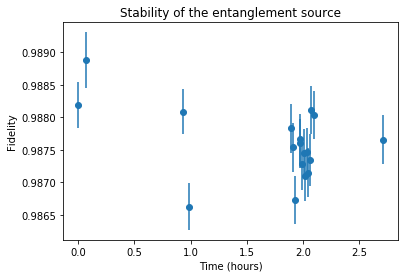

In [9]:
time=[]
ydata=np.zeros(len(states))
yerror=np.zeros(len(states))

### Converting the time label into minutes
for j in range(len(index_to_file)):
    time.append(int(index_to_file[j][-2:])/3600+int(index_to_file[j][-4:-2])/60+int(index_to_file[j][-6:-4])+24*int(index_to_file[j][-8:-6]))
first=np.min(time)

time=time-np.array([first]*len(index_to_file))
xdata=time
for index in range(len(states)):
    ydata[index]=np.real(np.round(states[index].fidelity(bell),5))
    yerror[index]=np.round(states[index].std,5)

plt.errorbar(xdata, ydata, yerror, fmt='o', label='data')
plt.ylabel('Fidelity')
plt.xlabel('Time (hours)')
plt.title('Stability of the entanglement source')